**Bitcoin Cash(bch)**

**Project Title: FutureCoin: Machine Learning-Based Crypto Price Prediction**

**1. Project Statement and Outcomes:**
1.The Cryptocurrency Price Prediction Using Machine Learning project aims to predict future cryptocurrency prices using time-series forecasting. The system will preprocess historical data, build predictive models, and visualize trends to offer valuable insights into future price movements.


2.A system that accurately predicts future cryptocurrency prices using time-series forecasting. It will offer valuable insights into market trends by analyzing historical data and visualizing predicted price movements, helping users make informed decisions in the cryptocurrency market.

**Milestone 2:**
Week 3-4: Modal Architecture, Training, Evaluation:
● Identify and create relevant features for time-series forecasting (e.g., moving averages, rolling statistics).

● Train machine learning models for time-series forecasting to predict future prices.

● Tune hyperparameters and validate model performance using standard metrics like MSE and MAE.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# -------------------------------------------------------------
# 1. LOAD DATA
# -------------------------------------------------------------
df = pd.read_csv("/content/BTCUSDT_FULL_2017_to_today.csv")
print("Loaded:", len(df))

# -------------------------------------------------------------
# 2. CLEANING
# -------------------------------------------------------------

# Convert ms to datetime
df["Open Time"] = pd.to_datetime(df["Open Time"], unit="ms")
df["Close Time"] = pd.to_datetime(df["Close Time"], unit="ms")
df["time"] = pd.to_datetime(df["time"], errors="coerce")

# Sort (important for time-series)
df = df.sort_values("Open Time").reset_index(drop=True)

# Check row count after cleaning
print("After cleaning:", len(df))

# -------------------------------------------------------------
# 3. FEATURE ENGINEERING
# -------------------------------------------------------------

# Returns
df["Return"] = df["Close"].pct_change()

# Volatility (24 hours)
df["Volatility"] = df["Close"].rolling(24).std()

# Moving averages
df["MA_10"] = df["Close"].rolling(10).mean()
df["MA_50"] = df["Close"].rolling(50).mean()

# RSI (14)
delta = df["Close"].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
df["RSI"] = 100 - (100 / (1 + rs))

# Drop initial NA from indicators
df = df.dropna()
print("After feature engineering:", len(df))

# -------------------------------------------------------------
# 4. TRAIN / TEST SPLIT (80/20 – time-based)
# -------------------------------------------------------------
split_idx = int(len(df) * 0.8)
train = df.iloc[:split_idx]
test = df.iloc[split_idx:]

print("Train:", len(train), "Test:", len(test))

# -------------------------------------------------------------
# 5. SELECT FEATURES
# -------------------------------------------------------------
features = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'Quote Volume', 'Trades', 'Taker Buy Base Volume',
    'Taker Buy Quote Volume', 'Ignore',
    'Return', 'Volatility', 'MA_10', 'MA_50', 'RSI'
]

target = "Close"

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

# -------------------------------------------------------------
# 6. SCALING
# -------------------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Final shapes:")
print("X_train:", X_train_scaled.shape)
print("X_test:", X_test_scaled.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


Loaded: 64525
After cleaning: 64525
After feature engineering: 7643
Train: 6114 Test: 1529
Final shapes:
X_train: (6114, 15)
X_test: (1529, 15)
y_train: (6114,)
y_test: (1529,)


XGBoost Performance
----------------------
MAE : 12.528635609977927
RMSE: 16.088136215265067
R²  : 0.9997749784315221


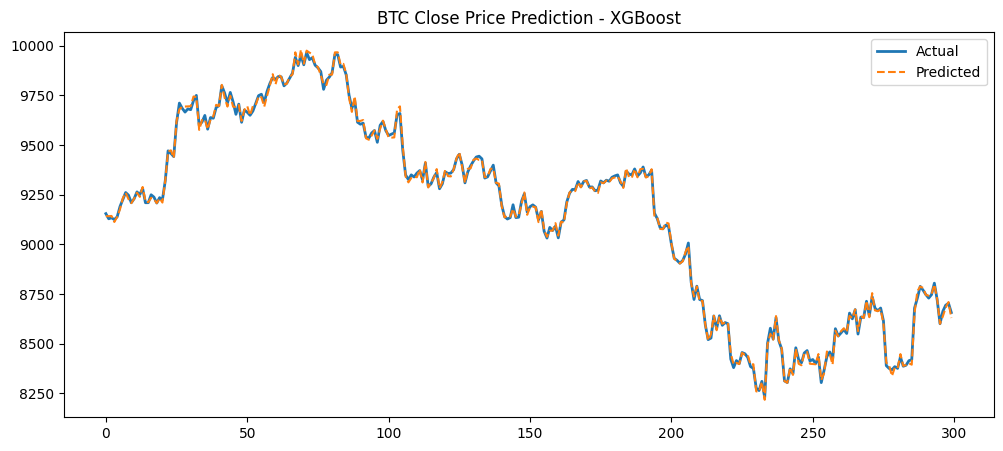

In [2]:
# --------------------------------------------
# XGBOOST MODEL
# --------------------------------------------
!pip install xgboost -q

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------
# 1. Define model
# --------------------------------------------
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

# --------------------------------------------
# 2. Train model
# --------------------------------------------
model.fit(X_train_scaled, y_train)

# --------------------------------------------
# 3. Predict
# --------------------------------------------
y_pred = model.predict(X_test_scaled)

# --------------------------------------------
# 4. Evaluation metrics
# --------------------------------------------
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("XGBoost Performance")
print("----------------------")
print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)

# --------------------------------------------
# 5. Plot actual vs predicted
# --------------------------------------------
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:300], label="Actual", linewidth=2)
plt.plot(y_pred[:300], label="Predicted", linestyle="dashed")
plt.title("BTC Close Price Prediction - XGBoost")
plt.legend()
plt.show()


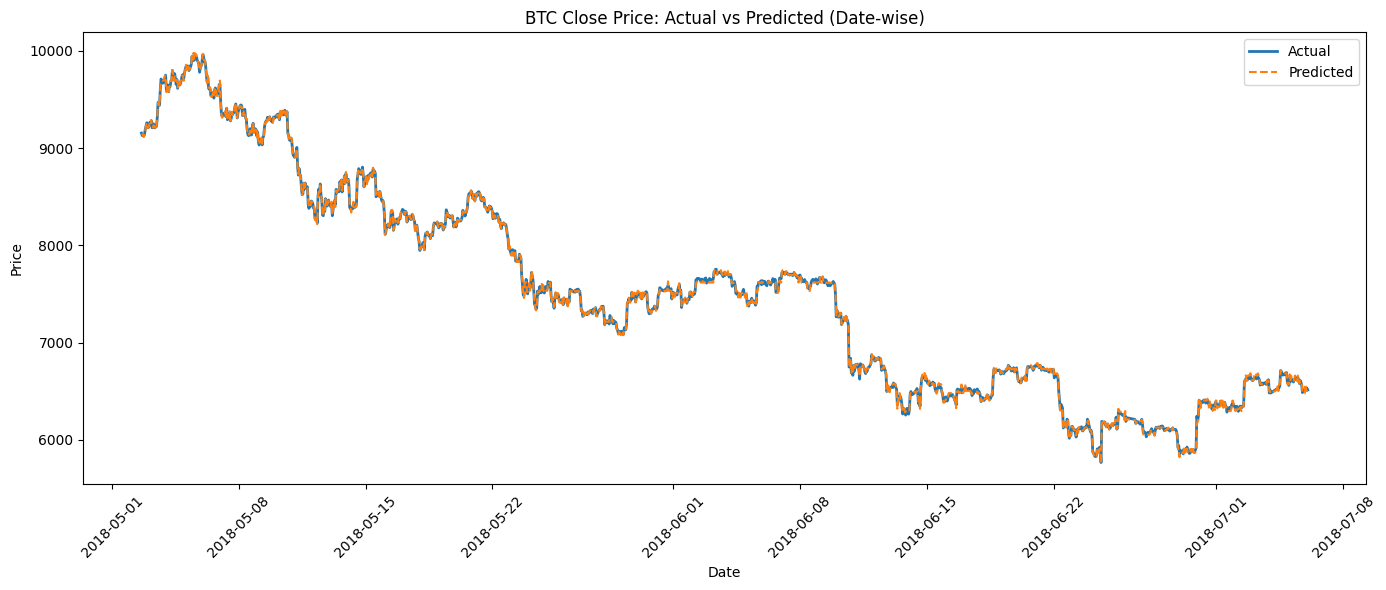

In [3]:
# --------------------------------------------
# Create a date index for test set
# --------------------------------------------

# Extract the last N dates equal to test size
test_dates = df['time'].iloc[-len(y_test):]

plt.figure(figsize=(14,6))
plt.plot(test_dates, y_test, label="Actual", linewidth=2)
plt.plot(test_dates, y_pred, label="Predicted", linestyle="dashed")

plt.title("BTC Close Price: Actual vs Predicted (Date-wise)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
